In [1]:
import numpy as np
import sys
import gsw
import xarray as xr
import numpy as np
from scipy import integrate
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
from jmd95 import densjmd95
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v4'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['SSHDYN','OBPNOPAB'],\
                                           years_to_load=range(1993,2018)).load() # if desired, add after 'SSH','NEW_VAR',... 'SSH','OBP',                                           

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  OBPNOPAB
loading files of  SSHDYN


In [3]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask[0,:])
# steric_height_anom = steric_height_jmd_xr # - steric_height_jmd_xr.mean(dim=['tile','j','i'])
# SH_global_mean_mon = (steric_height_anom*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
# SH_global_mean_mon = SH_global_mean_mon # - SH_global_mean_mon.mean(dim='time')

In [4]:
# --- SLA ---  
ssh_og = ecco_monthly_ds.SSHDYN*ocean_mask
# SSH_global_mean_mon = (ssh_og*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
# ssh_mgm = ssh_og - SSH_global_mean_mon  # subtract global spatial mean time series 
# ssh_anom = ssh_mgm - ssh_mgm.mean(dim='time')         # subtract time mean at each point
ssh_anom = ssh_og - ssh_og.mean(dim='time')
pssh = ssh_anom.polyfit(dim='time', deg=1)

-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0


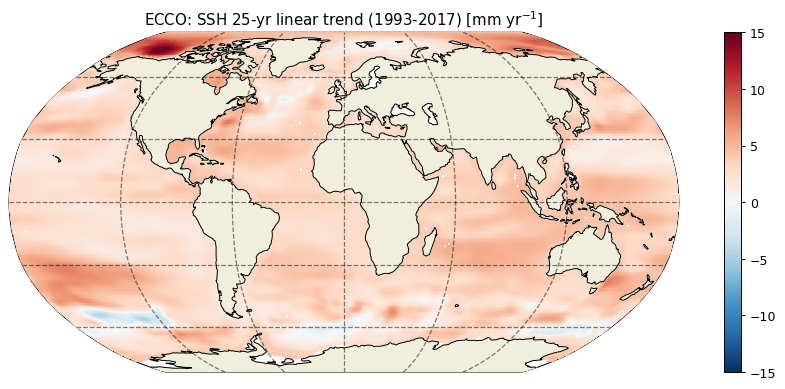

In [7]:
f1 = plt.figure(figsize=(13,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, np.array([1000])*pssh.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365, \
                              user_lon_0=0,plot_type='pcolormesh',show_colorbar=True, cmin=-15, cmax=15, dx=0.5,dy=0.5); # cmin=-0.3, cmax=0.3
plt.title('ECCO: SSH 25-yr linear trend (1993-2017) [mm yr$^{-1}$]');
f1.savefig('/Users/jakesteinberg/Documents/meetings/2022_10_GRACE/grace_ssh_trend.jpg', dpi=300)

In [14]:
SSHDYN_global_mean_mon = (ecco_monthly_ds.SSHDYN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
SSHDYN_global_mean_mon = SSHDYN_global_mean_mon - SSHDYN_global_mean_mon.mean(dim=['time'])
OBP_global_mean_mon = ((ecco_monthly_ds.OBPNOPAB)*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
OBP_global_mean_mon = OBP_global_mean_mon - OBP_global_mean_mon.mean(dim=['time'])

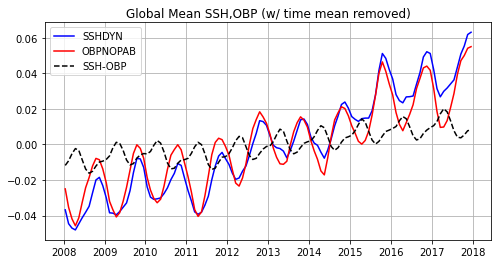

In [15]:
f, (ax1) = plt.subplots(1,1,figsize=(8,4))
steric_height_check =  SSHDYN_global_mean_mon - OBP_global_mean_mon
ax1.plot(steric_height_check.time, SSHDYN_global_mean_mon, color='b', label='SSHDYN');
ax1.plot(steric_height_check.time, OBP_global_mean_mon, color='r', label='OBPNOPAB');
ax1.plot(steric_height_check.time, 1*steric_height_check, color='k', label='SSH-OBP', linestyle='--');
# ax1.plot(steric_height_check.time, SH_global_mean_mon - SH_global_mean_mon.mean(dim='time'), color='g', label='steric height');
ax1.set_title('Global Mean SSH,OBP (w/ time mean removed)'); ax1.legend(); ax1.grid()

In [19]:
gmst = steric_height_check.polyfit(dim='time', deg=1)
gmst_coef = gmst.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365 # m/yr

In [22]:
gmst_coef.data*1000

2.250438915220206